In [1]:
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
from main import em_algorithm, sort_parameters
from constants import *
from faster import e_step, init_tau, init_X, log_likelihood, m_step, check_parameters
from graphs import draw_graph, random_graph, random_graph_from_parameters
from matplotlib import pyplot as plt

from sklearn.metrics import normalized_mutual_info_score

In [2]:
%reload_ext autoreload
%autoreload 2

Spectral Clustering

In [3]:
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

In [4]:
def spectral_clustering(G, k):

    nb_nodes = G.number_of_nodes()
    adjacency_matrix = nx.adjacency_matrix(G)
    degree_sequence = np.array([G.degree(node) for node in G.nodes()])
    D_inv = diags(1/degree_sequence)
    laplacian =  eye(nb_nodes) - D_inv @ adjacency_matrix

    eigenvalues, eigenvectors = eigs(laplacian, k=k, which = "SM")
    U = np.real(eigenvectors)
    kmeans = KMeans(n_clusters = k).fit(U)
    labels = list(kmeans.labels_)

    return dict(zip(G.nodes(), labels))

In [51]:
# Test the algorithm on a random graph
Q = 3
n = 300
alpha = np.random.uniform(0, 1, Q)
alpha = alpha / np.sum(alpha)
pi = np.zeros((Q, Q))
#fill upper triangle with values between 0.1 and 0.3
for i in range(Q):
    for j in range(i+1, Q):
        pi[i][j] = round(np.random.uniform(0.1, 0.5), 2)
#make pi symmetrical
for i in range(Q):
    for j in range(i):
        pi[i][j] = pi[j][i]
#random diagonal
for i in range(Q):
    pi[i][i] = round(np.random.uniform(0.3, 0.8), 2)

X, Z = random_graph_from_parameters(n, Q, alpha, pi)
true_classes_clusters = np.argmax(Z, axis=1)
alpha, pi = sort_parameters(alpha, pi)

In [52]:
pi

array([[0.78, 0.42, 0.2 ],
       [0.42, 0.32, 0.17],
       [0.2 , 0.17, 0.32]])

In [53]:
G = nx.from_numpy_array(X)

In [54]:
clustering = spectral_clustering(G, Q)
predicted_classes_clusters = list(clustering.values())

c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [55]:
print("The NMI score is: ", round(normalized_mutual_info_score(true_classes_clusters, predicted_classes_clusters), 2))

The NMI score is:  0.51


Text(0.5, 1.0, 'Predicted classes')

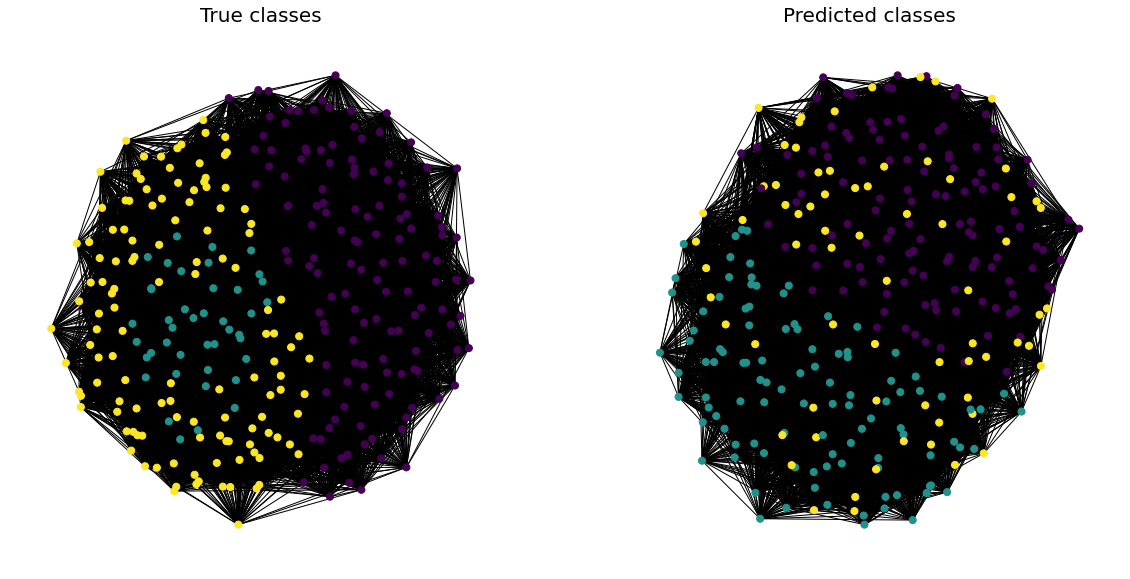

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

nx.draw(G, node_size=50, node_color=true_classes_clusters, ax=ax[0])
ax[0].set_title("True classes", fontsize=20)
nx.draw(G, node_size=50, node_color=predicted_classes_clusters , ax=ax[1])
ax[1].set_title("Predicted classes", fontsize=20)


In [59]:
estimated_alpha, estimated_pi, tau = em_algorithm(X, Q, tau_init = "random")
print("The NMI score (random tau init) is: ", round(normalized_mutual_info_score(true_classes_clusters, np.argmax(tau, axis=1)), 2))

After EM iteration 15/1000 : Log likelihood -25245.641457...Alpha [0.13575745 0.4409474  0.42329515]
The NMI score (random) is:  0.96


In [60]:
estimated_alpha, estimated_pi, tau = em_algorithm(X, Q, tau_init = "spectral")
print("The NMI score (spectral tau init) is: ", round(normalized_mutual_info_score(true_classes_clusters, np.argmax(tau, axis=1)), 2))

c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


After EM iteration 13/1000 : Log likelihood -25245.641457...Alpha [0.42329637 0.44094755 0.13575608]
The NMI score (spectral tau init) is:  0.96



## Karate graph

In [105]:
# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)

Number of nodes: 34
Number of edges: 78


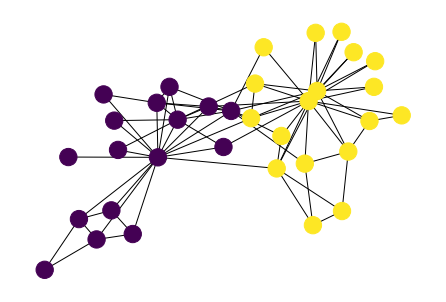

In [109]:
nx.draw(G, node_color=y)

In [110]:
clustering = spectral_clustering(G, 2)
predicted_classes_clusters = list(clustering.values())

c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [111]:
print("The NMI score is: ", round(normalized_mutual_info_score(y, predicted_classes_clusters), 2))

The NMI score is:  0.84


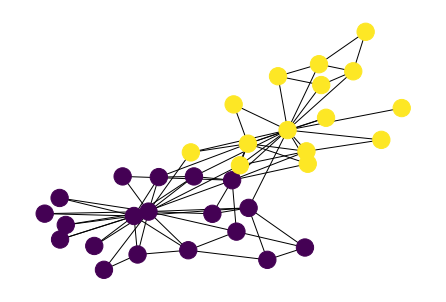

In [123]:
nx.draw(G, node_color = predicted_classes_clusters)

In [112]:
X = nx.adjacency_matrix(G).todense()
Q = 2

In [121]:
alpha, pi, tau = em_algorithm(X, Q)

After EM iteration 9/1000 : Log likelihood -193.531649...Alpha [0.14630067 0.85369933]


In [118]:
predicted_communities = np.argmax(tau, axis=1)

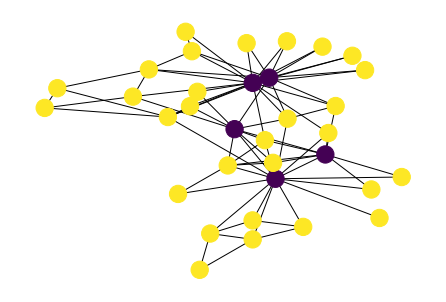

In [122]:
nx.draw(G, node_color=predicted_communities)

In [115]:
print("The NMI score (random tau init) is: ", round(normalized_mutual_info_score(y, np.argmax(tau, axis=1)), 2))

The NMI score (random tau init) is:  0.01


Example graph generation

In [80]:
G = LFR_benchmark_graph(n=100, tau1=2, tau2=1.5, mu=0.1, average_degree=5, min_community=40, max_community=50, seed=10)
G.remove_edges_from(nx.selfloop_edges(G))

In [81]:
communities = {frozenset(G.nodes[v]["community"]) for v in G}
communities = [list(community)  for community in communities]
communities = {node: i for i, community in enumerate(communities) for node in community}

colors = ["red", "blue", "green", "yellow", "orange", "purple", "black", "pink", "brown", "cyan"]
nodes_colors = [colors[communities[node]] for node in G.nodes]

In [88]:
true_classes_clusters = [communities[node] for node in G.nodes]

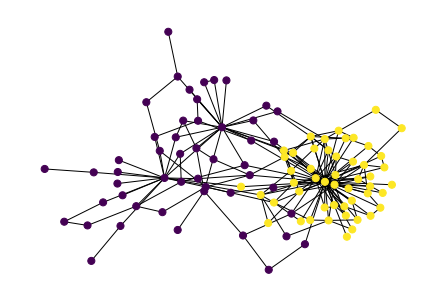

In [89]:
nx.draw(G, node_size=50, node_color=true_classes_clusters)

In [90]:
clustering = spectral_clustering(G, 2)
predicted_classes_clusters = list(clustering.values())

c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


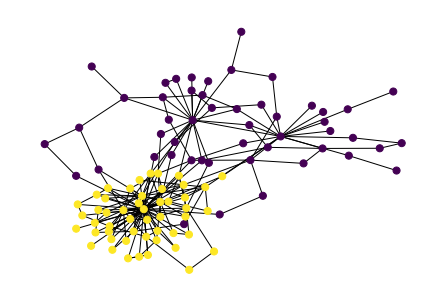

In [92]:
nx.draw(G, node_size=50, node_color=true_classes_clusters)

In [94]:
normalized_mutual_info_score(true_classes_clusters, predicted_classes_clusters)

0.5512937220658846

In [95]:
X = nx.adjacency_matrix(G).todense()
Q = 2

In [103]:
alpha, pi, tau = em_algorithm(X, Q)

After EM iteration 11/1000 : Log likelihood -711.363187...Alpha [0.04978137 0.95021863]


In [97]:
predicted_communities = np.argmax(tau, axis=1)
predicted_nodes_colors = [colors[node] for node in predicted_communities]

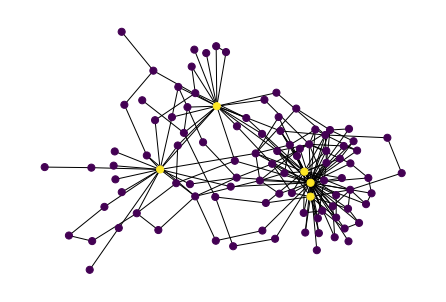

In [99]:
nx.draw(G, node_size=50, node_color=np.argmax(tau, axis=1))

In [101]:
normalized_mutual_info_score(predicted_communities, true_classes_clusters)

0.002376254062259117

In [ ]:


# with profile(
#    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=False
# ) as prof:
#    with record_function("em_algorithm"):
estimated_alpha, estimated_pi, tau = em_algorithm(X, Q)
estimated_alpha, estimated_pi = sort_parameters(estimated_alpha, estimated_pi)

print("Estimated alpha", estimated_alpha)
print("Alpha", alpha)
print("Estimated pi", estimated_pi)
print("Pi", pi)

In [15]:
n = 1000 # number of nodes
tau1 = 2 # Power law exponent for the degree distribution
tau2 = 1.2 # Power law exponent for the community size distribution
mu = 0.1 # Fraction of intra-community edges incident to each node
average_degree = 10 # Average node degree
min_degree = None # Minimum node degree
max_degree = 50 # Maximum node degree
min_community = 10 # Minimum number of nodes in a community
max_community = 50 # Maximum number of nodes in a community
seed = 42 # Seed for random number generator

In [69]:
G = LFR_benchmark_graph(n, tau1, tau2, mu, average_degree, min_degree, max_degree, min_community, max_community, seed=seed)
G.remove_edges_from(nx.selfloop_edges(G))

In [70]:
communities = {frozenset(G.nodes[v]["community"]) for v in G}
communities = [list(community)  for community in communities]
communities = {node: i for i, community in enumerate(communities) for node in community}

38
